<a href="https://colab.research.google.com/github/danielcoblentz/DepartmentalCourseAnalysis/blob/main/CS200_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# libraries for project
import requests
from collections import Counter
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from wordcloud import WordCloud, STOPWORDS
import time

## Pages used for scraping

For this project, I scraped data from the Hood College 2024–2025 Catalog, specifically the course listing pages for three departments:

[Computer Science (CS)](https://hood.smartcatalogiq.com/2024-2025/hood-college-2024-2025-catalog/undergraduate-courses/cs-computer-science/)

[Mathematics (MATH)](https://hood.smartcatalogiq.com/2024-2025/hood-college-2024-2025-catalog/undergraduate-courses/math-mathematics/)

[Biology (BIOL)](https://hood.smartcatalogiq.com/2024-2025/hood-college-2024-2025-catalog/undergraduate-courses/biol-biology/)

These pages contain course descriptions, credit hours, and offering details, but require HTML parsing to extract the relevant data.

## Interest in these pages
As a Computer Science major, I was interested in analyzing the structure and content of the CS curriculum I'm directly part of. I wanted to see what topics are emphasized, how courses are distributed across levels, and how Computer science  compares to other departments like Math and Biology. These pages provided a meaningful and personalized dataset focused in my academic experience.


## Broad project goals
The main goal of this project is to collect and analyze course offerings across departments at Hood College to answer questions like:

1) Which departments offer more advanced (300/400 level) courses?

2) What topics are most frequently mentioned in course descriptions?



3) How are courses distributed across semesters?

To answer these, I performed web scraping, cleaned and structured the data into DataFrames, and then applied text analysis and data visualization techniques (e.g., word clouds, bar charts) to uncover patterns in course content and department structure.

## Step 1: Web Scraping — Collecting raw course information

In this step to answer the first question above, I use the `requests` and `BeautifulSoup` libraries to scrape course data from the Hood College catalog. Specifically, I extract:
- The full course title ( "CS 202 Computer Science II")
- The course description
- The number of credits
- The semester(s) when the course is offered

The HTML structure is semi-structured, so I look ahead from each course title to find the relevant information nearby.


In [26]:
#This function takes in a url and department name from there it extracts the inofrmation from that URL passed in and gets the following (dept name, course title, description, credits and when that course is offered)
# for now the data is not entrely cleaned/formatted this is just for getting the bulk inofrmation which we can shave down later
def scrape_department(url, department_name):
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    raw_courses = [] #store course data
    headers = soup.find_all("h2") # find all h2 tags(course titles)


#get the course titles
    for h in headers:
        title_link = h.find('a')
        if not title_link:
            continue

        full_title = title_link.text.strip()

        #get the course description and credits
        desc_div = h.find_next_sibling("div", class_="desc")
        credits_div = desc_div.find_next_sibling("div", class_="credits") if desc_div else None

        #course terms when its offered
        offered_text = "N/A"
        current = credits_div
        for _ in range(5):
            if current:
                current = current.find_next_sibling()
                if current and current.name == "h3" and current.text.strip() == "Offered":
                    if current.next_sibling and isinstance(current.next_sibling, str):
                        offered_text = current.next_sibling.strip()
                    elif current.find_next_sibling():
                        offered_text = current.find_next_sibling().text.strip()
                    break



# add to raw_courses list above above
        raw_courses.append({
            "Department": department_name,
            "raw_title": full_title,
            "raw_description": desc_div.get_text(strip=True) if desc_div else "",
            "raw_credits": credits_div.get_text(strip=True) if credits_div else "N/A",
            "offered": offered_text
        })

    return raw_courses

## Step 2: Cleaning and Structuring the Data

Now that I have the raw course entries, I extract and organize the following fields:
- `Course Code`: the department and course number (e.g., "CS 200")
- `Course Title`: the name of the course (e.g., "Applied Computing II")
- `Credits`: the number of credit hours (converted to clean format)
- `Offered`: the semester or availability (e.g., "Fall Semester", "As Needed")
- `Description`: the full course description

The cleaned data is stored in a pandas DataFrame for analysis. Displayed below (you may modify the dataframe to view it in another format).


In [27]:
#cleans and structures the raw course content, it takes in the returned list from the previous block as a argument
def clean_courses(raw_data):
    cleaned_courses = []


  # Split the raw title into course code and title
    for entry in raw_data:
        parts = entry["raw_title"].split(maxsplit=2)
        if len(parts) < 3:
            continue

        course_code = f"{parts[0]} {parts[1]}"
        course_title = parts[2] if len(parts) == 3 else ' '.join(parts[2:])


 # Append the cleaned course data to the list
        cleaned_courses.append({
            "Department": entry["Department"],
            "Course Code": course_code,
            "Course Title": course_title,
            "Credits": entry["raw_credits"].replace("Credits", "").strip(),
            "Offered": entry["offered"],
            "Description": entry["raw_description"]
        })

    return pd.DataFrame(cleaned_courses)

In [28]:
#links for scraping each dept (add more as needed or add more if interested) then pass into functions defined above

cs_url = 'https://hood.smartcatalogiq.com/2024-2025/hood-college-2024-2025-catalog/undergraduate-courses/cs-computer-science/'
math_url = 'https://hood.smartcatalogiq.com/2024-2025/hood-college-2024-2025-catalog/undergraduate-courses/math-mathematics/'
bio_url = 'https://hood.smartcatalogiq.com/2024-2025/hood-college-2024-2025-catalog/undergraduate-courses/biol-biology/'

#scrape data fro each dept
cs_raw = scrape_department(cs_url, 'CS')
math_raw = scrape_department(math_url, 'Math')
bio_raw = scrape_department(bio_url, 'Biology')

In [29]:
#clean the scraped data & verify the df contents
df_cs = clean_courses(cs_raw)
df_math = clean_courses(math_raw)
df_bio = clean_courses(bio_raw)

df_math.head(10) # add more here to view different data frames for each dept
#df_math.shape

,Department,Course Code,Course Title,Credits,Offered,Description
0,Math,MATH 098,Algebra Review I,1.0,Both Semesters and Summer,Prerequisite: Level I placement on the Basic M...
1,Math,MATH 099,Algebra Review II,1.0,Both Semesters and Summer,Prerequisite:MATH 098or permission of instruct...
2,Math,MATH 106,Explorations in Elementary Mathematics I,3.0,Fall Semester,Prerequisite:MATH 098or Level IB placement on ...
3,Math,MATH 107,Explorations in Elementary Mathematics II,3.0,Spring Semester,Prerequisite:MATH 098or Level IB placement on ...
4,Math,MATH 108,Explorations in Elementary Mathematics III,3.0,Spring Semester,Prerequisite:MATH 106.Early childhood and elem...
5,Math,MATH 111,Mathematics Everywhere,3.0,Both Semesters,Prerequisite:MATH 098or Level IB placement on ...
6,Math,MATH 111A,The Mathematics of Daily Life,3.0,Either Semester,Prerequisite:MATH 098or Level IB placement on ...
7,Math,MATH 111B,The Mathematics of Democracy,3.0,Either Semester,Prerequisite:MATH 098or Level IB placement on ...
8,Math,MATH 111G,The Mathematics of Games and Sports,3.0,Either Semester,Prerequisites:MATH 098or Level IB placement on...
9,Math,MATH 112,Applied Statistics,3.0,Summer and/or Both Semesters,Prerequisite:MATH 098or Level IB placement on ...


## Step 3: Exploratory Data Analysis (EDA)
### Answer to question one
`"Which departments offer more advanced (300/400 level) courses?"`


In this section, I explore patterns across the Computer Science, Mathematics, and Biology curricula using data visualizations and text analysis.

### Goals of EDA:
- Compare how each department distributes courses across levels (100–400).
- Identify the most common keywords used in course descriptions for each department.
- Highlight key differences in academic focus and structure between departments.

In [30]:
# Combine all departments into one DataFrame
df_combined = pd.concat([df_cs, df_math, df_bio], ignore_index=True)

# get course level (100,200,..)
df_combined['Course Level'] = df_combined['Course Code'].apply(lambda x: x.split()[1][0] + "00")

# group by department and level
level_counts_all = df_combined.groupby(['Department', 'Course Level']).size().reset_index(name='Count')

# barchart showing them grouped by dept
chart = alt.Chart(level_counts_all).mark_bar().encode(
    x=alt.X('Course Level:O', sort=['100', '200', '300', '400'], title='Course Level'),
    y=alt.Y('Count:Q', title='Number of Courses'),
    color='Department:N',
    column=alt.Column('Department:N', title='Department'),
    tooltip=['Department', 'Course Level', 'Count']
).properties(
    title='Number of Courses by level for CS, Math, and Biology'
)

chart


alt.Chart(...)

### Why this chart?

This bar chart visualizes the number of courses offered at each level (000,100, 200, 300, 400) across three departments: Computer Science, Mathematics, and Biology. It helps compare how each department structures its curriculum. From introductory to advanced coursework and reveals where they place the most emphasis.

`*Note:` I noticed that there is technically a 0-level course offered only in Mathematics. There are no other 0-level courses in BIO or CS.

### What it shows:

- CS has a strong concentration of courses at the 300 level, indicating a focus on advanced technical training.
- Math has a more balanced distribution, with a noticeable number of 100-level and 300-level courses, suggesting a steady progression.
- Biology has a significant number of 400-level courses, which may reflect lab-intensive or capstone-style classes in upper years.

## Answer to reseach question two.

`"2) What topics are most frequently mentioned in course descriptions?"`


### Prerequisite for Generating the Word Cloud
Before generating the word clouds, I noticed that many of the most frequent words were boilerplate phrases shared across all course descriptions—regardless of department or level. These included generic terms like "students," "course," and "prerequisites" that don't show any meaningful inofrmation. To correct for this and focus on  relevant keywords, I applied a custom list of stop words to filter out common academic language and improve the accuracy of the analysis.

Additionally, I separated the stop words into two categories: shared stop words and department-specific ones. Keeping all stop words in a single hash map was causing important keywords from specific departments to be incorrectly removed.

In [63]:
# Shared stopwords(across all depts)
base_stopwords = STOPWORDS.union({
    'course', 'courses', 'students', 'including', 'topics', 'will', 'may', 'also',
    'used', 'use', 'study', 'introduction', 'description', 'provide', 'provides',
    'designed', 'offered', 'semester', 'department', 'credit', 'credits',
    'prerequisite', 'prerequisites', 'permission', 'instructor', 'include', 'take',
    'lecture', 'inventory', 'selected', 'required',"majors"
})


# CS-specific stopwords
cs_stopwords = base_stopwords.union({
    'cs', 'systems', 'problem', 'solving', 'programming', 'skills', 'computer',
    'data', 'based', 'approach', 'intensive', 'real', 'world', 'analysis',
    'information', 'applications', 'learn', 'language', 'languages', 'software',
    'technology', 'impact',"level"
})


# Math-specific stopwords
math_stopwords = base_stopwords.union({
    'math', 'mathematics', 'mathematical', 'methods', 'equations', 'theory',
    'basic', 'principles', 'functions', 'linear', 'algebra', 'geometry', 'discussed',
    'application', "098or","IB placement", "Level IB","IB placement","level","placement","skills",'applications',"real","solving",'number',
    'emphasis','ib','work'
})


# Biology-specific stopwords
bio_stopwords = base_stopwords.union({
    'biology', 'biol', 'biological', 'laboratory', 'senior', 'junior', 'major',
    'structure', 'function', 'concepts', 'level', 'explore', 'understanding',
    'perspectives', 'emphasize', 'emphasis', 'techniques', 'student', 'taking',
    'reading', 'finals', '203', '149', 'chem', 'introductory','without','110'
})


## Issues:
One issue I ran into during this project (which you might’ve noticed) is that some of the content scraped from the website included extra text above the main course descriptions. As far as I know, there’s no consistent way to remove that automatically. However, I found a bit of a workaround by adding some of those repeated phrases to the stop words list, which helped clean things up a bit.

In [32]:
#wrapped wordclouds into functions so we can call them repeatedly as needed if we pass in more course information
def generate_wordcloud(df, dept_name, stopwords):
    text_blob = ' '.join(df['Description'])
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        stopwords=stopwords
    ).generate(text_blob)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Common Words in {dept_name} Course Descriptions')
    plt.show()


testing the wordcloud on the 3 dept from above:
Note: The custom stop words i added are open ot interpretation I did the best i could to only include hte words that i belvie have hte most meaning so feel free to change them as needed.

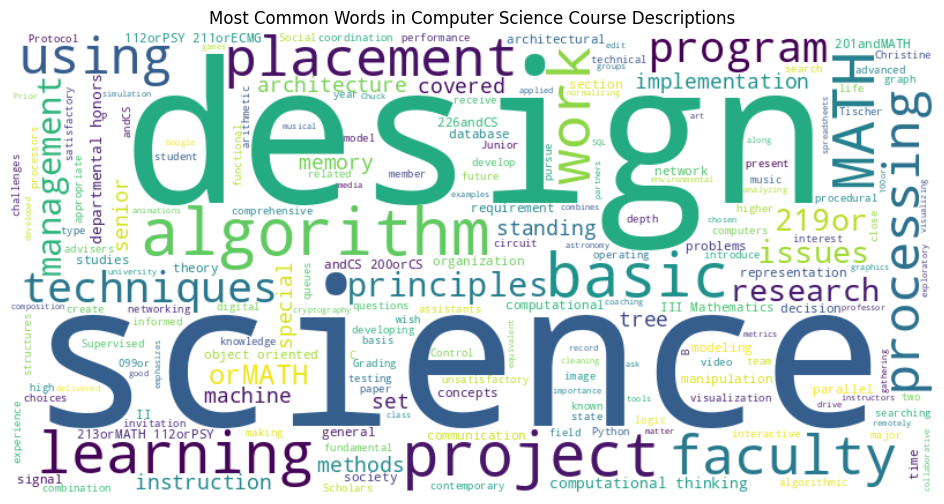

In [33]:
generate_wordcloud(df_cs, "Computer Science", cs_stopwords)

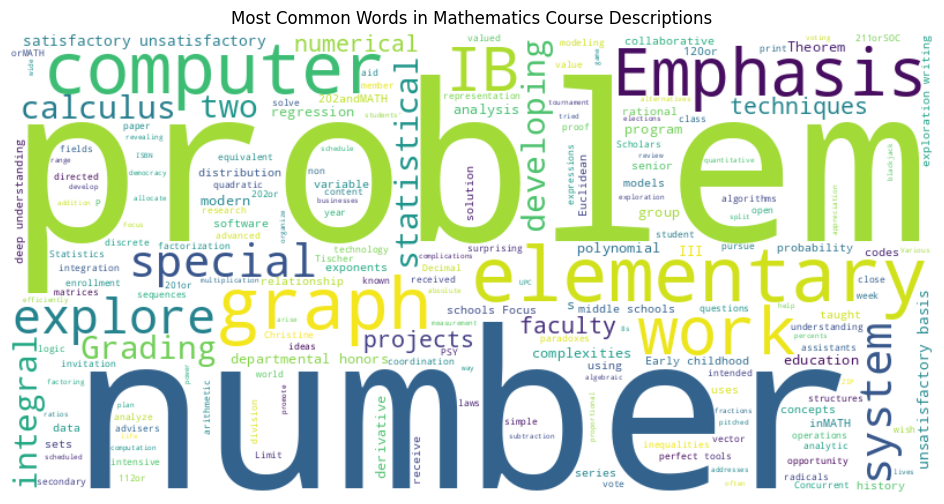

In [54]:
generate_wordcloud(df_math, "Mathematics", math_stopwords)

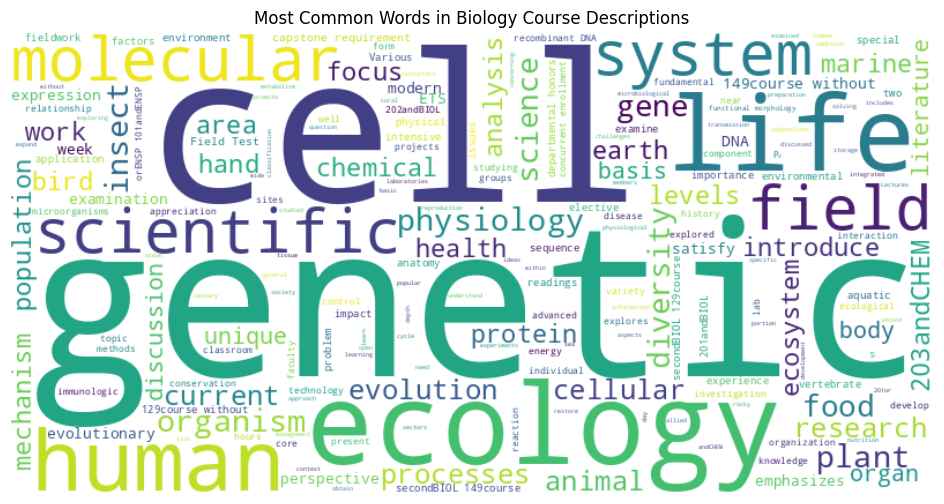

In [35]:
generate_wordcloud(df_bio, "Biology", bio_stopwords)

### Why these word clouds?

These word clouds display the most frequently used keywords in course descriptions for the CS, Math, and Biology departments. By visualizing the language used in each curriculum, we can quickly identify common themes, technical focuses, and departmental priorities without reading every description manually.

### What they show:

In Computer Science, keywords like design, math, and processing appear frequently, highlighting a focus on technical skills and computing fundamentals.

The Math word cloud emphasizes terms like theory, equations, and problem solving, reflecting a curriculum centered on abstract reasoning and problem-solving.

Biology features words such as genetic, scientific, and cells, pointing to hands-on scientific investigation and life sciences content.

##
Key Takeaways from Our Data Exploration
`Different Departments, Different Course Focus:`


When we looked at the course levels, we noticed that each department leans toward different stages of the curriculum. For example, Computer Science has a lot of 300-level classes, while Biology has more 400-level ones — probably because of specialized or lab-heavy courses at the upper level.

Each Field Has Its Own Language:
The word clouds gave us a nice visual of what each department emphasizes. CS talks a lot about data and systems, Math leans into theory and analysis, and Biology focuses more on organisms, cells, and lab work. It really shows how each area has its own academic goals.

## Finding the Most Frequent Keywords Across Departments
### Internal verfiication of EDA
In this section, I analyze the most commonly used words in course descriptions for the Computer Science, Mathematics, and Biology departments. By filtering out boilerplate academic language using a custom stop word list, I was able to focus on meaningful terms that reflect each department’s unique focus.

`Additionally` the world cloud is great for getting an intial visual of the data we are wokring with however it does not provide us with the actual counts of each word that is what I will be finding in this next code block to verify the results.

In [64]:
# function to get the actual counts of keywords excluding stop words above and running it on each dept
def get_top_keywords(df, dept_name, top_n=10):
    # Pick stopwords for the department
    if dept_name == "CS":
        stopwords = cs_stopwords
    elif dept_name == "Math":
        stopwords = math_stopwords
    elif dept_name == "Biology":
        stopwords = bio_stopwords
    else:
        stopwords = base_stopwords

    all_text = ' '.join(df['Description']).lower()
    words = re.findall(r'\b\w+\b', all_text)
    filtered_words = [word for word in words if word not in stopwords]
    word_counts = Counter(filtered_words)

    print(f"\nTop {top_n} keywords in {dept_name} course descriptions:")
    for word, count in word_counts.most_common(top_n):
        print(f"{word}: {count}")


      #run for each dept
get_top_keywords(df_cs, "CS")
get_top_keywords(df_math, "Math")
get_top_keywords(df_bio, "Biology")


Top 10 keywords in CS course descriptions:
design: 13
science: 12
basic: 9
algorithms: 9
math: 8
work: 8
learning: 8
placement: 7
computational: 7
faculty: 7

Top 10 keywords in Math course descriptions:
elementary: 9
problem: 8
computer: 8
numbers: 7
special: 6
explore: 6
problems: 6
graphs: 5
grading: 5
satisfactory: 5

Top 10 keywords in Biology course descriptions:
ecology: 13
field: 13
life: 11
scientific: 10
genetics: 10
molecular: 10
physiology: 9
human: 8
diversity: 8
food: 8


**Which departments have the highest number of upper-level (300/400) courses?**
EDA + ans

In [44]:
# Combine all departments into one DataFrame called 'df_all'
df_all = pd.concat([df_cs, df_math, df_bio], ignore_index=True)

# extract course level (e.g., 100, 200, etc.)
df_all['Course Level'] = df_all['Course Code'].apply(lambda x: x.split()[1][0] + "00")

# filter for 300 and 400 level courses
upper_level = df_all[df_all['Course Level'].isin(['300', '400'])]

# count by department
upper_counts = upper_level['Department'].value_counts().reset_index()
upper_counts.columns = ['Department', 'Upper-Level Course Count']

print("Departments ranked by number of 300/400-level courses:")
print(upper_counts)

Departments ranked by number of 300/400-level courses:
  Department  Upper-Level Course Count
0    Biology                        29
1         CS                        24
2       Math                        21


### Answer to research question three
`How are courses distributed across semesters?`

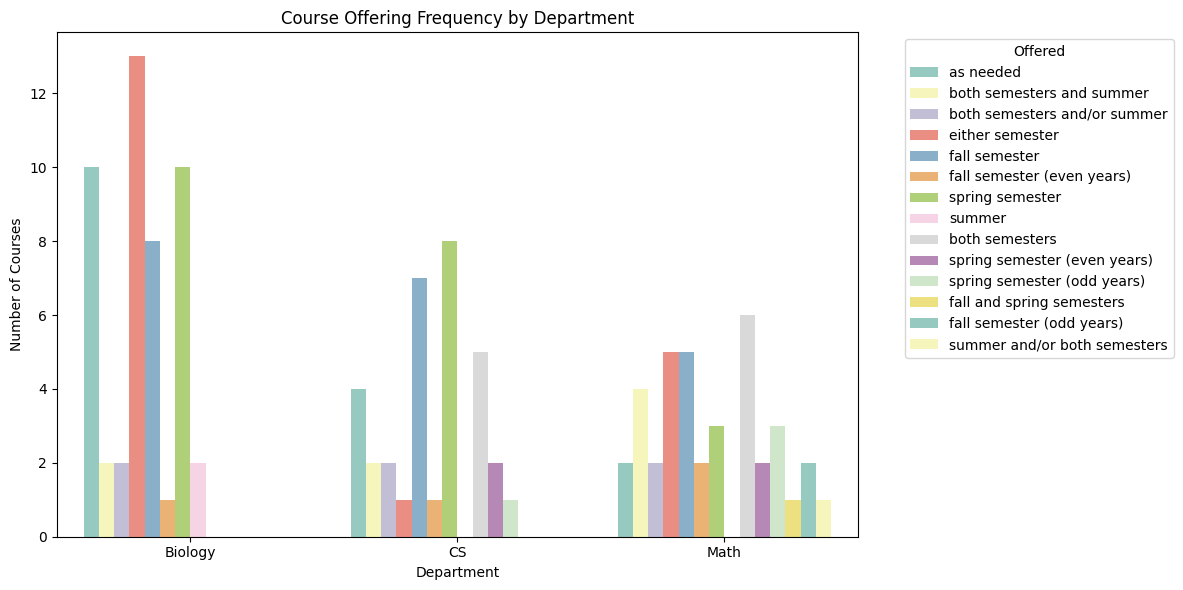

In [66]:
#get hte frequency of offerings by dept
# Fill in missing "Offered" entries if any
# Fill missing values and normalize case
df_all['Offered'] = df_all['Offered'].fillna('Unknown').str.lower()

# Group and count
offered_counts = df_all.groupby(['Department', 'Offered']).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.barplot(data=offered_counts, x='Department', y='Count', hue='Offered', palette='Set3')
plt.title('Course Offering Frequency by Department')
plt.ylabel('Number of Courses')
plt.xlabel('Department')
plt.legend(title='Offered', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

 ### Why a bar chart?

A bar chart is an effective choice for this type of data because:

 The "Offered" variable is categorical, meaning it represents distinct groups or categories. Bar charts are designed to visualize the distribution of data across categories.

Comparison: Bar charts allow for easy comparison of the frequency or count of courses offered in each category. The height of each bar directly represents the number of courses, making it straightforward to identify patterns and differences.

### Findings

`Biology` has the widest variety of offering terms, with many courses available in the fall, spring, or either semester, suggesting flexibility and higher course volume.

`Computer Science` (CS) has a strong cluster around spring semester and either semester, indicating a focus on recurring core courses.

`Math` shows more uniform distribution across terms, but fewer high-frequency offerings overall compared to Biology.




### Visual Summary and Reflections

To support my research questions, I created three visualizations:

- **Course Level Distribution Chart (Altair):**  
  Helps compare how departments distribute courses across levels, clearly showing CS's focus on 300-levels and Biology’s emphasis on 400-levels.

- **Department Word Clouds:**  
  Reveal the most emphasized themes in each curriculum by filtering out boilerplate terms. This visualization gives a quick, intuitive sense of department priorities.

- **Course Offering Frequency Chart (Seaborn):**  
  Highlights seasonal trends in how often courses are available. Math and CS offer more courses in both semesters, while Biology varies more.

These visualizations helped directly answer my research questions and offered deeper insights into departmental focus, structure, and accessibility.


## Ethical Considerations

Although the data is publicly available, a few ethical considerations are worth noting:

- **Bias in course descriptions:** Language used in course descriptions may reflect institutional or disciplinary norms rather than actual course experience. This could lead to biased interpretations, especially when using word frequency analysis.


- **Data consistency:** Course descriptions vary in length and detail. Some may include rich, descriptive language while others are brief, which can skew keyword analysis.

- **Generalization limitations:** The findings apply only to the current academic year (2024–2025) and may not reflect trends across different years or institutions.

- **Stop words issue mentioned earier**

## Conclusion

This project explored course offerings across three departments at Hood College: Computer Science, Mathematics, and Biology. By scraping and analyzing the course catalog, I was able to identify patterns in curriculum structure, keyword emphasis, credit distribution, and seasonal availability.

Key findings included:
- The Computer Science department has a strong emphasis on 300-level courses, while Biology leans more heavily into 400-level courses.
- Distinct themes are visible in course descriptions: CS focuses on data and *systems*, Math on theory and analysis*, and Biology on organisms and laboratory work.
- Biology courses tend to carry more credits on average, and course offerings vary in frequency across departments.

These insights provide a clearer picture of how departments structure their academic programs and highlight differences in department focus.
